<a href="https://colab.research.google.com/github/harithaareddy123/Machine-learning/blob/main/CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1319 sha256=ae00027c466eef9827800e51b9aecc268ebe0e7369db1591a83f8f80c63dfcd0
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76de31b718cde792c953bfd11d2414a72f204b56
Successfully built unzip


In [4]:
#!unzip gdrive/MyDrive/CNN_assignment

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
115


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## train dataset here

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
#validation dataset here

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [12]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


### Visualize the data


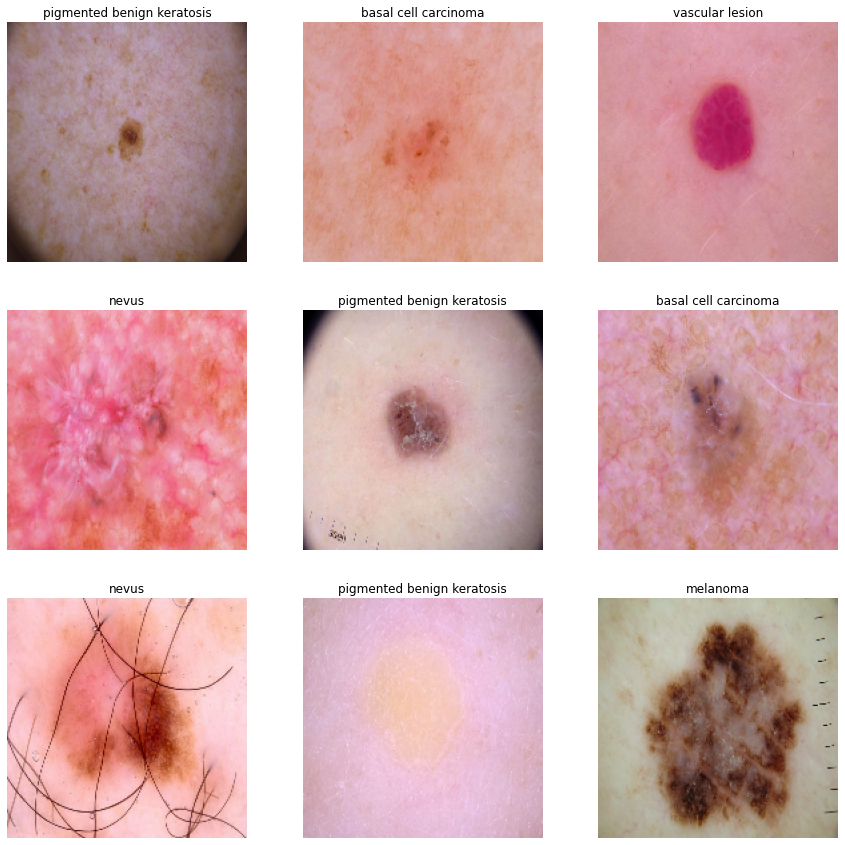

In [13]:
import matplotlib.pyplot as plt

#training or validation data to visualize
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [15]:
#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

#Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [17]:

#total classes
num_classes = 9

#Sequential model
model = Sequential([
  # Performing rescaling              
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Adding 2D convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  # Downsampling the input along its spatial dimensions (height and width) by using the maximum pooling technique.
  layers.MaxPooling2D(),

  # Adding another 2D convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Downsampling the input along its spatial dimensions (height and width) by using the maximum pooling technique.
  layers.MaxPooling2D(),

  # Adding another 2D convolution layer
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  # Downsampling the input along its spatial dimensions (height and width) by using the maximum pooling technique.
  layers.MaxPooling2D(),

  # Flattening to 1D feature vector
  layers.Flatten(),

  # Adding fully connected layer
  # A fully connected layer is also known as a dense layer.
  layers.Dense(512, activation='relu'),

  # Added final dense layer to map output 
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 160ms/step - loss: 2.1605 - accuracy: 0.2215 - val_loss: 1.9027 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7962 - accuracy: 0.3354 - val_loss: 1.6392 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5893 - accuracy: 0.4247 - val_loss: 1.4415 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4133 - accuracy: 0.5033 - val_loss: 1.4635 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2515 - accuracy: 0.5580 - val_loss: 1.4481 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2430 - accuracy: 0.5619 - val_loss: 1.5400 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.0558 - accuracy: 0.6300 - val_loss: 1.4754 - val_accuracy: 0.5481
Epoch 8/20


### Visualizing training results

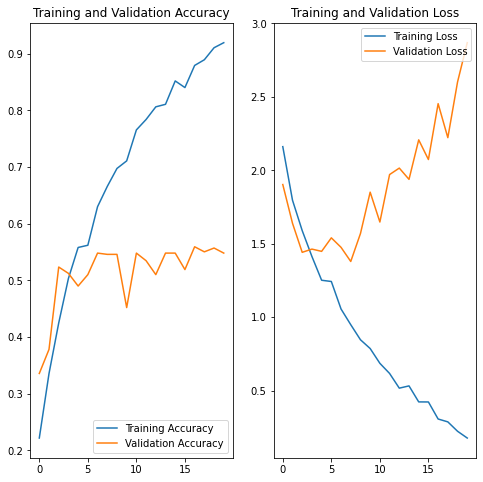

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





1.We see high training accuracy(90%) and low validation accuracy(53%).   

2.With incresing epoch, loss got decresed for training but there is increment in validation loss.  
3.There is difference between training accuracy and validation accuracy , we can say model is somehow overfit.

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

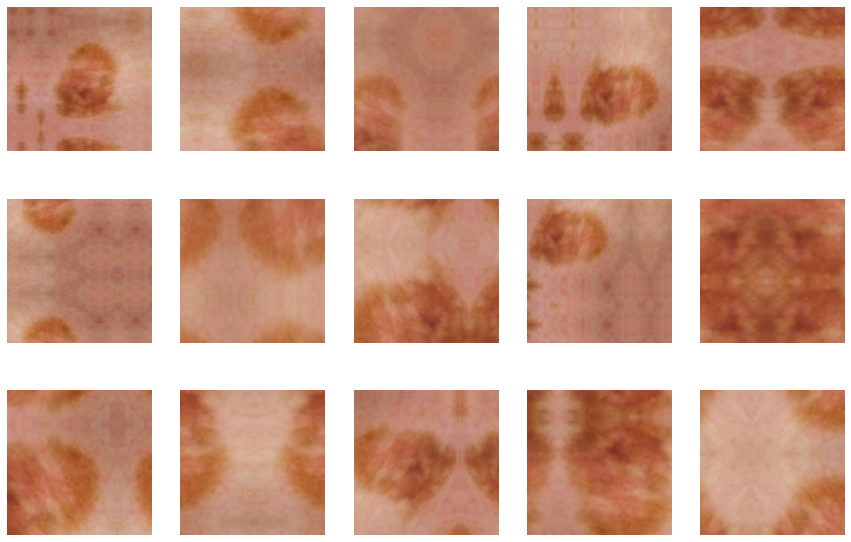

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(15, 10))
for images, _ in train_ds.take(1):
  for i in range(15):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
## Your code goes here
num_classes = 9

#Creating a Sequential model
model = Sequential([

  data_augmentation,

  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(512, activation='relu'),

  layers.Dense(num_classes)
])



### Compiling the model

In [25]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 57ms/step - loss: 2.2339 - accuracy: 0.2221 - val_loss: 1.9447 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 3s 52ms/step - loss: 1.9518 - accuracy: 0.2768 - val_loss: 2.0127 - val_accuracy: 0.2528
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.8143 - accuracy: 0.3125 - val_loss: 1.6806 - val_accuracy: 0.3826
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6837 - accuracy: 0.3594 - val_loss: 1.7697 - val_accuracy: 0.3736
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 1.6916 - accuracy: 0.3521 - val_loss: 1.6738 - val_accuracy: 0.3736
Epoch 6/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6421 - accuracy: 0.3800 - val_loss: 1.5531 - val_accuracy: 0.4161
Epoch 7/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5829 - accuracy: 0.4157 - val_loss: 1.5563 - val_accuracy: 0.4430
Epoch 8/20
56

### Visualizing the results

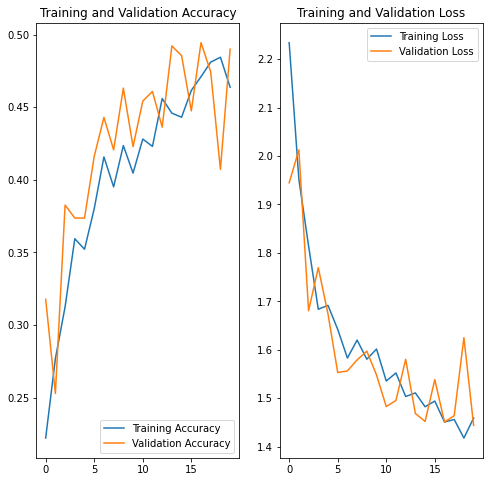

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



1.   Now we can see significance drop in difference b/w training and validation accuracy . Now only difference is about 1%.
2.  Since both training and validation accuracy are near, we are able to remove overfitting.
3. Traininga and validation accuracy got reduced to 45% which is not good . It indicates  we had to modify model to learn more.




#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,basal cell carcinoma


Class=4, n=357 (15.945%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)


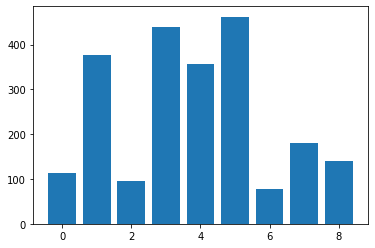

In [30]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = df['Path'], df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

We have a Class imabalance here

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


** Which class has the least number of samples?**   

Class 6

**Which classes dominate the data in terms proportionate number of samples?**   

 Class 1,3,4 and 5

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F232C39EAD0>: 100%|██████████| 500/500 [00:19<00:00, 26.27 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F232C364D10>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F232C46ED90>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F232C303890>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F232C6359D0>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F232C534210>: 100%|██████████| 500/500 [00:18<00:00, 26.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F232C436910>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F232F734CD0>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F232C303D10>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000021.jpg_49d07a48-e664-4ecb-8db7-805d6f2dc75e.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000486.jpg_4c2733d8-40eb-42ab-aff8-5d132d0cd777.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027447.jpg_8afb0f2a-ea4c-4405-8274-ef9e13383f66.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028190.jpg_f2740db5-7f84-4235-935d-b1ca22fd36dc.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0025605.jpg_1ae9bdc8-7e72-4412-9c4c-53b67e0797df.jpg',
 '/content/gdri

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:

## your code goes here
num_classes = 9

#Creating a Sequential model
model = Sequential([
              
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(512, activation='relu'),

  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
epochs = 30
## Your code goes here
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 183ms/step - loss: 2.1695 - accuracy: 0.1641 - val_loss: 1.9415 - val_accuracy: 0.2368
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 1.6855 - accuracy: 0.3435 - val_loss: 1.4869 - val_accuracy: 0.4269
Epoch 3/30
169/169 [==============================] - 31s 179ms/step - loss: 1.4159 - accuracy: 0.4525 - val_loss: 1.3637 - val_accuracy: 0.4803
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.3130 - accuracy: 0.4920 - val_loss: 1.2524 - val_accuracy: 0.5360
Epoch 5/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1692 - accuracy: 0.5540 - val_loss: 1.2317 - val_accuracy: 0.5397
Epoch 6/30
169/169 [==============================] - 31s 179ms/step - loss: 0.9661 - accuracy: 0.6302 - val_loss: 1.0834 - val_accuracy: 0.6058
Epoch 7/30
169/169 [==============================] - 31s 180ms/step - loss: 0.7866 - accuracy: 0.7075 - val_loss: 0.9677 - val_ac

#### **Todo:**  Visualize the model results

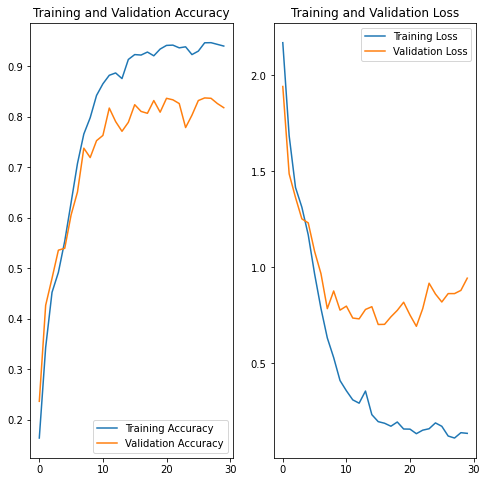

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We got 94% training accuracy and 81% validation accuracy. so we can see significance increase in training and validation accuracy . 
So we can say rebalancing classes helped  improvizing model performance .